In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


run = 'simple_4'

folder = f'../../data/manager_v3/{run}'

train_folder = os.path.join(folder, 'metrics')
merge_file = os.path.join(folder, 'metrics.parquet')

plot_folder = f'plots/{run}'

make_dir(plot_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not os.path.isfile(merge_file):
    dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
    df = pd.concat(dfs)
    df.to_parquet(merge_file)
else:
    df = pd.read_parquet(merge_file)

In [3]:
df.columns

Index(['eps', 'gamma', 'lr', 'target_update_freq', 'job_id', 'round_number',
       'sampling', 'update_step', 'metric', 'value'],
      dtype='object')

In [4]:
non_labels = ['round_number', 'sampling', 'update_step', 'metric', 'value', 'job_id']

labels = [c for c in df.columns if c not in non_labels]


In [5]:
df['metric'].unique()

array(['punishments', 'contributions', 'common_good',
       'contributor_payoff', 'manager_payoff', 'next_reward', 'q_min',
       'q_max', 'q_mean'], dtype=object)

In [6]:
df[df['sampling'] == 'greedy']

,eps,gamma,lr,target_update_freq,job_id,round_number,sampling,update_step,metric,value
16,0.2,0.5,1.e-3,100,target_update_freq_100__lr_1.e-3__gamma_0.5__e...,0,greedy,0,punishments,9.785001
17,0.2,0.5,1.e-3,100,target_update_freq_100__lr_1.e-3__gamma_0.5__e...,1,greedy,0,punishments,10.691751
18,0.2,0.5,1.e-3,100,target_update_freq_100__lr_1.e-3__gamma_0.5__e...,2,greedy,0,punishments,11.627750
19,0.2,0.5,1.e-3,100,target_update_freq_100__lr_1.e-3__gamma_0.5__e...,3,greedy,0,punishments,12.355751
20,0.2,0.5,1.e-3,100,target_update_freq_100__lr_1.e-3__gamma_0.5__e...,4,greedy,0,punishments,12.970000
...,...,...,...,...,...,...,...,...,...,...
71995,0.2,0.5,1.e-3,1000,target_update_freq_1000__lr_1.e-3__gamma_0.5__...,11,greedy,4980,q_mean,490.475281
71996,0.2,0.5,1.e-3,1000,target_update_freq_1000__lr_1.e-3__gamma_0.5__...,12,greedy,4980,q_mean,492.421844
71997,0.2,0.5,1.e-3,1000,target_update_freq_1000__lr_1.e-3__gamma_0.5__...,13,greedy,4980,q_mean,492.941742
71998,0.2,0.5,1.e-3,1000,target_update_freq_1000__lr_1.e-3__gamma_0.5__...,14,greedy,4980,q_mean,492.190399


In [7]:
import statsmodels.formula.api as smf
w = (
    (df['metric'] == 'contributions') &
    (df['sampling'] == 'greedy')
)
dfs = df[w].copy()
w_max = (dfs['update_step'] == dfs['update_step'].max())
dfs = dfs[w_max].copy()

for l in labels:
    dfs[l] = dfs[l].astype(str)


label_ref = {
    'eps': '0.1',
    'gamma': '1.0',
    'lr': '1.e-3',
}


label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]


results = smf.glm(f"value ~ {'+'.join(label_str)}", data=dfs).fit()
results_df = results.summary2().tables[1]

# print('metric accuracy - positive coef -> better')
# results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')
results_df

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,15.771988,0.338320,46.618528,0.000000e+00,15.108892,16.435083
"C(eps, Treatment(reference='0.1'))[T.0.2]",0.072339,0.276237,0.261871,7.934207e-01,-0.469076,0.613754
"C(gamma, Treatment(reference='1.0'))[T.0.5]",-1.577955,0.338320,-4.664088,3.099880e-06,-2.241050,-0.914860
"C(gamma, Treatment(reference='1.0'))[T.0.8]",-1.940057,0.338320,-5.734381,9.786909e-09,-2.603152,-1.276961
"C(lr, Treatment(reference='1.e-3'))[T.3.e-4]",-0.791331,0.276237,-2.864678,4.174332e-03,-1.332746,-0.249916
target_update_freq[T.1000],-0.517458,0.276237,-1.873239,6.103543e-02,-1.058873,0.023957


In [14]:
df['sampling'].unique()

array(['eps-greedy', 'greedy'], dtype=object)

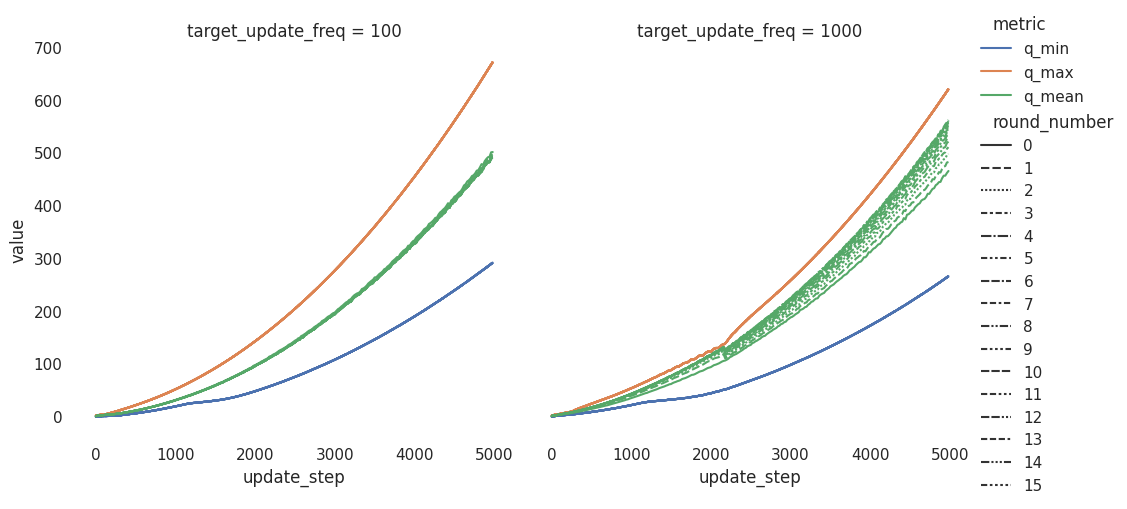

In [17]:
selection = {'eps': 0.2, 'gamma': 1.0, 'lr': '3.e-4', 'metric': 'next_reward', 'sampling': 'greedy', 'target_update_freq': 1000}

focus = ['update_step', 'metric', 'round_number', 'target_update_freq']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if k not in focus
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['q_min', 'q_max', 'q_mean'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

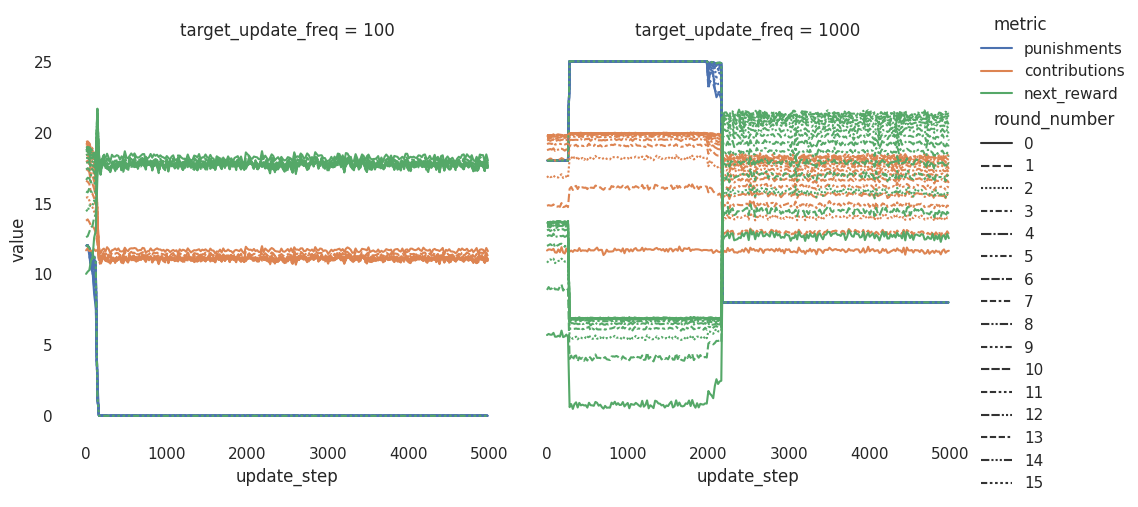

In [19]:
# selection = {'eps': 0.2, 'gamma': 0.8, 'lr': '3.e-4', 'metric': 'next_reward', 'sampling': 'greedy', 'target_update_freq': 1000}

focus = ['update_step', 'metric', 'round_number', 'target_update_freq']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if k not in focus
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'next_reward'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))


In [ ]:
# selection = {'eps': 0.2, 'gamma': 0.8, 'lr': '3.e-4', 'metric': 'next_reward', 'sampling': 'greedy', 'target_update_freq': 1000}

focus = ['update_step', 'metric', 'target_update_freq']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if k not in focus
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'next_reward'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))